## AUTO ML CLASSIFICATION MODEL WITH RAPIDS

## FORTH ML EXPERIMENT

USING TARGET created by MEAN of **SUCCESS SCORE 2** which uses INFLUENCER SCORE as the following:

> $$ Influencer = \left(RI\over {fans} \right) $$

For more information see notebook _Feature Engineering 3.ipynb_

**We exclude CANADA from the training**

**USING TPOT WITH NVIDIA RAPIDS GPU SUPPORT**

** BEST MODEL: XGBOOST CLASSIFIER WITH MAX-ABS SCALER

#### PRECISION 0.84 = RECALL 0.85 = ACCURACY 0.85

In [2]:
# #!conda init bash
# !conda activate rapids-22.02
# !python3 -c "import cudf, cuml; print(cudf.__version__); print(cuml.__version__)"
# !conda deactivate

In [3]:
import pandas as pd
from functools import reduce

In [4]:
business = pd.read_csv('./data/business.csv')
attributes = pd.read_csv('./data/atributtes_clean.csv', low_memory=False)
categories = pd.read_csv('./data/categories_fixed.csv')
hours = pd.read_csv('./data/hours_fixed.csv')
gps = pd.read_csv('./data/gps_clustering.csv')
checkins = pd.read_csv('./data/n_checkins.csv')
top_tips = pd.read_csv('./data/top_tips.csv')
target2 = pd.read_csv('./data/target2.csv')
sentiment = pd.read_csv('./data/sentiment_ok_unique.csv')

In [5]:
data_frames = [business, attributes, categories, hours, gps, checkins, top_tips, target2]
full_data_2 = reduce(lambda left,right: pd.merge(left,right,on='business_id', how='left'), data_frames)

In [6]:
full_data_2.columns

Index(['business_id', 'name', 'postal_code', 'latitude_x', 'longitude_x',
       'stars', 'review_count', 'is_open', 'good_ambience', 'garage',
       'BusinessAcceptsCreditCards', 'RestaurantsPriceRange2', 'BikeParking',
       'WiFi', 'delivery', 'GoodForKids', 'OutdoorSeating',
       'RestaurantsReservations', 'HasTV', 'RestaurantsGoodForGroups',
       'Alcohol', 'ByAppointmentOnly', 'Caters', 'RestaurantsAttire',
       'NoiseLevel', 'meal_diversity', 'Restaurants', 'Food', 'Shopping',
       'Home Services', 'Beauty & Spas', 'Nightlife', 'Health & Medical',
       'Local Services', 'Bars', 'Automotive', 'total_categories', '7days',
       'weekends', 'n_open_days', 'mean_total_hours_open', 'mean_open_hour',
       'mean_close_hour', 'latitude_y', 'longitude_y', 'areas',
       'number_visits', 'number_tips', 'Unnamed: 0', 'success_score_2',
       'target'],
      dtype='object')

In [7]:
to_drop = ['name', 'postal_code', 'latitude_x', 'longitude_x', 'stars', 'review_count', 'is_open', 'latitude_y', 'longitude_y',  'number_visits', 'number_tips', 'Unnamed: 0', '7days', 'n_open_days', 'total_categories', 'mean_open_hour', 'mean_close_hour','success_score_2']#, 'target' ]
full_data_2.drop(to_drop, inplace=True, axis=1)

In [8]:
full_data_2 = full_data_2.loc[full_data_2['areas'] != 7, :]

In [9]:
full_data_2.index = full_data_2['business_id']
full_data_2.drop('business_id', axis=1, inplace=True)

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from sklearn.utils import class_weight

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

#from functions import run_exps

import warnings
warnings.filterwarnings('ignore') 

In [11]:
# Imputing with MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

# Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

full_data_2['mean_total_hours_open'] = mice_imputer.fit_transform(full_data_2['mean_total_hours_open'].values.reshape(-1,1))

In [12]:
full_data_2.fillna(0, inplace=True)

In [13]:
full_data_3 = full_data_2.copy()

In [14]:
ohe = OneHotEncoder(sparse=False)
to_transform = ['areas', 'RestaurantsPriceRange2']
X = ohe.fit_transform(full_data_2[to_transform])
X = pd.DataFrame(X, columns=ohe.get_feature_names(to_transform), index=full_data_2.index)
full_data_2 = pd.concat([full_data_2, X], axis=1)
full_data_2.drop(to_transform, axis=1, inplace=True)

In [15]:
full_data_2.shape

(145875, 45)

In [16]:
full_data_2.isna().sum().sum()

0

In [17]:
#!pip install wandb
#import wandb
#wandb.init(project="henry-tf-g2-ml1")

In [ ]:
!pip install tpot
import tpot

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    full_data_2.drop('target', axis=1), full_data_2['target'], test_size=0.2,
    random_state=42)

In [21]:
full_data_2.to_csv('./data/automl_gpu_7.csv', index = True)

In [22]:
pipeline_optimizer = tpot.TPOTClassifier(generations=5, #number of iterations to run the training
                                        population_size=20, #number of individuals to train
                                        cv=10, max_time_mins = 100,
                                        config_dict="TPOT cuML") #number of folds in StratifiedKFold
pipeline_optimizer.fit(X_train, y_train) #fit the pipeline optimizer - can take a long time

print(pipeline_optimizer.score(X_test, y_test)) #print scoring for the pipeline
pipeline_optimizer.export('automl_pipeline_gpu_class.py') #export the pipeline - in Python code!

In [ ]:
!pip install wandb plotly
import wandb
wandb.login()

In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler
from xgboost import XGBClassifier

# Average CV score on the training set was: 0.8492544987146529
exported_pipeline = make_pipeline(
    MaxAbsScaler(),
    XGBClassifier(alpha=10, learning_rate=0.1, max_depth=8, min_child_weight=6, n_estimators=100, n_jobs=1, subsample=0.8500000000000001, tree_method="gpu_hist", verbosity=0)
)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_test)

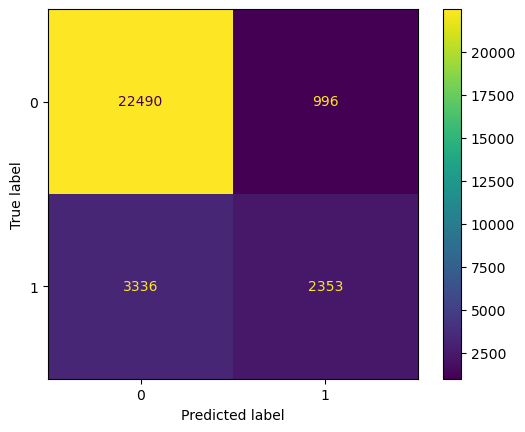

[[22490   996]
 [ 3336  2353]]
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     23486
           1       0.70      0.41      0.52      5689

    accuracy                           0.85     29175
   macro avg       0.79      0.69      0.72     29175
weighted avg       0.84      0.85      0.84     29175



In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

matrix = confusion_matrix(y_test, results)
cm_display = ConfusionMatrixDisplay(matrix)
cm_display.plot()
plt.show()

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, results))
print(classification_report(y_test, results))